In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import seaborn as sns
from random import randint

import json
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

In [2]:
def get_length(series):
    lengths = []
    for i in series.str.split(" "):
        lengths.append(len(i))
    return lengths

In [3]:
def convert_json_to_df(file_path, sample_fraction=0.01):
    # Open the json file and load it as a dictionary
    with open(file_path, "r") as f:
        dic = json.load(f)
    
    # Initialize our columns
    text = []
    hypothesis = []
    label = []
    
    # Iterate through documents and their labels and hypothesis
    for doc in dic["documents"]:
        for nda in doc["annotation_sets"][0]['annotations']:
            txt = doc["text"]
            for span in doc["spans"]:
                # Add the text to the text column
                text.append(txt[span[0]:span[1]])
                # Add the label to label column
                label.append(doc["annotation_sets"][0]['annotations'][nda]["choice"])
                # Add the hypothesis to hypothesis column
                hypothesis.append(dic["labels"][nda]["hypothesis"])
    
    # Create a DataFrame with the previous columns
    df = pd.DataFrame({"text": text, "hypothesis": hypothesis, "label": label})
    
    # Randomly sample 10% of the DataFrame
    sampled_df = df.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
    
    return sampled_df


In [4]:
# read json files of train, test and validation as data frames
train_df = convert_json_to_df("/kaggle/input/dataset-contractnli/train.json")
validation_df = convert_json_to_df("/kaggle/input/contractnli-dev/dev.json")
test_df = convert_json_to_df("/kaggle/input/dataset-contractnli/test.json")

In [5]:
train_df.head()

,text,hypothesis,label
0,The parties irrevocably agree that the courts ...,Receiving Party may create a copy of some Conf...,Entailment
1,By: By:,Some obligations of Agreement may survive term...,Entailment
2,"b) That any ideas, patentable or not patentabl...",Receiving Party shall not use any Confidential...,Entailment
3,Agreement (hereinafter called the “Agreement”)...,Agreement shall not grant Receiving Party any ...,Entailment
4,(b) the Receiving Party's information technolo...,Receiving Party may create a copy of some Conf...,Entailment


In [6]:
print(train_df.shape, test_df.shape, validation_df.shape)

(5592, 3) (1710, 3) (867, 3)


In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer

In [8]:
# Create a table to display the evaluation metrics
def show_metrics(accuracy, precision, recall, f1):
    table = PrettyTable()
    table.field_names = ["Metric", "Value"]
    table.add_row(["Accuracy", f"{accuracy:.4f}"])
    table.add_row(["Precision", f"{precision:.4f}"])
    table.add_row(["Recall", f"{recall:.4f}"])
    table.add_row(["F1-score", f"{f1:.4f}"])
    # Print the table
    print(table)

In [9]:
def tokenize(data, batch_size=10000):
    all_encodings = {'input_ids': [], 'attention_mask': []}
    for i in tqdm(range(0, len(data), batch_size), desc="Tokenizing in Batches"):
        batch = data.iloc[i:i + batch_size]
        encodings = tokenizer(
            text=batch['text'].tolist(),
            text_pair=batch['hypothesis'].tolist(),
            truncation=True,
            padding="max_length",
            max_length=512
        )
        all_encodings['input_ids'].extend(encodings['input_ids'])
        all_encodings['attention_mask'].extend(encodings['attention_mask'])
    return all_encodings



In [10]:
class ContractNLI(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
        # Here we ensure the label is an integer tensor
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

In [11]:
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:558: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from tqdm import tqdm

label_mapping = {"NotMentioned": 0, "Entailment": 1, "Contradiction": 2}

train_labels = [label_mapping[label] for label in train_df['label'].tolist()]
valid_labels = [label_mapping[label] for label in validation_df['label'].tolist()]
test_labels = [label_mapping[label] for label in test_df['label'].tolist()]
test_encodings = tokenize(test_df)
train_encodings = tokenize(train_df)
valid_encodings = tokenize(validation_df)

Tokenizing in Batches: 100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


In [13]:
train_dataset = ContractNLI(train_encodings, train_labels)
valid_dataset = ContractNLI(valid_encodings, valid_labels)
test_dataset = ContractNLI(test_encodings, test_labels)

In [14]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [15]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    accuracy = (preds == p.label_ids).mean()
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [16]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.720400,0.732465,0.700115,0.704017,0.700115,0.688109
2,0.701400,0.701726,0.698962,0.703901,0.698962,0.682834
3,0.628700,0.682059,0.708189,0.709814,0.708189,0.703400


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=1050, training_loss=0.7649920631590343, metrics={'train_runtime': 1384.8582, 'train_samples_per_second': 12.114, 'train_steps_per_second': 0.758, 'total_flos': 4414069854904320.0, 'train_loss': 0.7649920631590343, 'epoch': 3.0})

In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def evaluate_and_save_predictions(trainer, test_dataset, test_df, label_mapping, output_file="test_predictions.csv"):
    """
    Evaluates the model on the test dataset, computes metrics, and saves predictions along with true labels to a file.
    
    Args:
    - trainer (Trainer): The HuggingFace Trainer with a trained model.
    - test_dataset (Dataset): The test dataset for evaluation.
    - test_df (DataFrame): The original test dataframe containing `text` and `hypothesis` columns.
    - label_mapping (dict): Dictionary mapping label names to numeric indices.
    - output_file (str): File path for saving predictions. Defaults to "test_predictions.csv".
    
    Returns:
    - None
    """
    # Make predictions on the test dataset
    predictions = trainer.predict(test_dataset)
    
    # Convert predictions to label indices
    pred_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids  # Extract true labels directly from predictions

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
    accuracy = accuracy_score(true_labels, pred_labels)

    # Display the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Prepare results for saving
    test_results = pd.DataFrame({
        'Text': test_df['text'],              # Original text for reference
        'Hypothesis': test_df['hypothesis'],  # Hypothesis for reference
        'True_Label': [list(label_mapping.keys())[label] for label in true_labels],
        'Predicted_Label': [list(label_mapping.keys())[label] for label in pred_labels]
    })

    # Save the results to a CSV file
    test_results.to_csv(output_file, index=False)
    print(f"Test predictions saved to {output_file}")

# Usage example:
# evaluate_and_save_predictions(trainer, test_dataset, test_df, label_mapping, output_file="test_predictions.csv")


In [18]:
evaluate_and_save_predictions(trainer, test_dataset, test_df, label_mapping, output_file="test_predictions.csv")

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Accuracy: 0.6485
Precision: 0.6501
Recall: 0.6485
F1 Score: 0.6376
Test predictions saved to test_predictions.csv


In [19]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [20]:
label_mapping = {"NotMentioned": 0, "Entailment": 1, "Contradiction": 2}

train_labels = [label_mapping[label] for label in train_df['label'].tolist()]
valid_labels = [label_mapping[label] for label in validation_df['label'].tolist()]
test_labels = [label_mapping[label] for label in test_df['label'].tolist()]
test_encodings = tokenize(test_df)
train_encodings = tokenize(train_df)
valid_encodings = tokenize(validation_df)

Tokenizing in Batches: 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


In [21]:
train_dataset = ContractNLI(train_encodings, train_labels)
valid_dataset = ContractNLI(valid_encodings, valid_labels)
test_dataset = ContractNLI(test_encodings, test_labels)

In [22]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    accuracy = (preds == p.label_ids).mean()
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with tor

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.780100,0.729219,0.704729,0.708809,0.704729,0.687683
2,0.804300,0.698161,0.703576,0.708703,0.703576,0.685636
3,0.638100,0.684697,0.698962,0.698479,0.698962,0.697447


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=2097, training_loss=0.762243922574212, metrics={'train_runtime': 1151.9607, 'train_samples_per_second': 14.563, 'train_steps_per_second': 1.82, 'total_flos': 4413990695804928.0, 'train_loss': 0.762243922574212, 'epoch': 3.0})

In [23]:
result = trainer.evaluate(test_dataset)
accuracy = result['eval_accuracy']
precision = result['eval_precision']
recall = result['eval_recall']
f1 = result['eval_f1']

# Generate predictions for the test dataset
roberta_predictions, roberta_labels, _ = trainer.predict(test_dataset)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [24]:
roberta_results = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}
roberta_results

{'accuracy': 0.6678362573099416,
 'precision': 0.664504448507661,
 'recall': 0.6678362573099416,
 'f1': 0.6614018415181461}

In [25]:
import gc
gc.collect()


0

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Confusion Matrix:
[[394 263  51]
 [137 673  23]
 [ 54  40  75]]


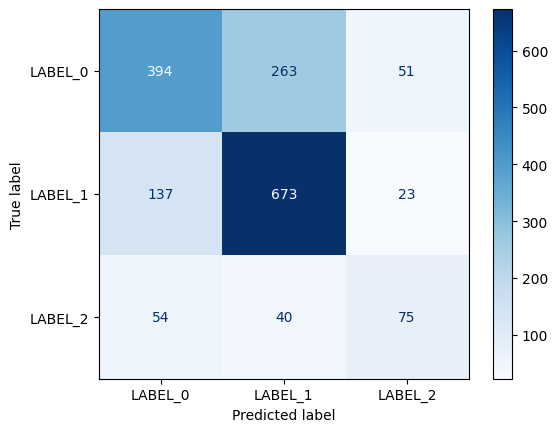

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions for the test dataset
roberta_predictions, roberta_labels, _ = trainer.predict(test_dataset)

# Convert logits to predicted labels
# Assuming `roberta_predictions` contains logits
predicted_labels = roberta_predictions.argmax(axis=1)

# Compute confusion matrix
cm = confusion_matrix(roberta_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=trainer.model.config.id2label.values())
disp.plot(cmap='Blues')
